In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO

In [2]:
s = """
       |Material A|Material A|Material B|Material B|Material C|Material C|Material D|Material D|Material E|Material E\n
Team|Error|Size|Error|Size|Error|Size|Error|Size|Error|Size\n
 #1     | 9.6        | 1576       | 5.6        | 1576       | 8.5        | 1576       | 55.3       | 1576       | 13.5       | 1576       \n
 #2     | 8.5        | 90653      | 2.0        | 90653      | 4.5        | 90653      | 15.9       | 16449      | 8.0        | 16449      \n
 #3     | 40.5       | 11012900   | 7.8        | 11012900   | 25.2       | 11012900   | 44.1       | 11012900   | 36.3       | 11012900   \n
 #4     | 4.9        | 8914       | 2.2        | 8914       | 2.9        | 8914       | 20.7       | 8914       | 9.0        | 8914       \n
 #5     | 16.0       | 2396048    | 3.7        | 2396048    | 6.8        | 2396048    | 201.4      | 2396048    | 19.3       | 2396048    \n
 #6     | 4.6        | 25923      | 2.8        | 25923      | 6.8        | 25923      | 39.5       | 25923      | 9.3        | 25923      \n
 #7     | 72.4       | 118785     | 58.0       | 118785     | 66.1       | 118785     | 71.3       | 118785     | 53.7       | 118785     \n
 #8     | N/A        | N/A        | N/A        | N/A        | N/A        | N/A        | N/A        | N/A        | N/A        | N/A        \n
 #9     | 21.3       | 60         | 7.9        | 60         | 14.4       | 60         | 93.9       | 60         | 21.5       | 60         \n
 #10    | 45.9       | 9728       | 6.9        | 29600      | 26.4       | 21428      | 59.4       | 1740       | 68.4       | 8052       \n
 #11    | 99.8       | 28564      | 88.7       | 28564      | 93.7       | 28564      | 99.3       | 28564      | 97.8       | 28564      \n
 #12    | 19.9       | 86728      | 7.4        | 86728      | 7.7        | 86728      | 65.9       | 86728      | 85.1       | 86728      \n
 #13    | 4.8        | 1755       | 2.2        | 1755       | 3.4        | 1755       | 22.2       | 1755       | 6.6        | 1755       \n
 #14    | 32.1       | 610        | 33.4       | 760        | 27.7       | 748        | 47.1       | 700        | 28.5       | 610        \n
 #15    | 351.2      | 329537     | 138.7      | 329537     | 439.5      | 329537     | 810.1      | 329537     | 152.8      | 329537     \n
 #16    | 38.8       | 81         | 6.9        | 56         | 21.0       | 61         | 50.5       | 23         | 28.2       | 53         \n
 #17    | 26.1       | 139938     | 12.9       | 139938     | 15.6       | 139938     | 79.1       | 139938     | 19.1       | 139938     \n
 #18    | 10.0       | 1084       | 3.7        | 1084       | 5.0        | 1084       | 30.7       | 1084       | 19.9       | 1084       \n
 #19    | 24.5       | 1033729    | 8.0        | 1033729    | 8.9        | 1033729    | 67.9       | 276225     | 118.7      | 1033729    \n
 #20    | 13.1       | 116061     | 6.4        | 116061     | 9.3        | 116061     | 29.9       | 116061     | 25.7       | 116061     \n
 #21    | 7.2        | 1419       | 1.9        | 2197       | 3.5        | 2197       | 29.6       | 1419       | 9.1        | 2454       \n
 #22    | 15.6       | 23000      | 4.3        | 23000      | 9.3        | 23896      | 79.2       | 32546      | 98.0       | 25990      \n
 #23    | 12.4       | 17342      | 3.8        | 17342      | 10.7       | 17342      | 30.0       | 17342      | 14.1       | 17342      \n
 #24    | 15.5       | 4285       | 6.1        | 4285       | 10.1       | 4285       | 67.9       | 4285       | 77.0       | 4285       \n
"""

In [3]:
mat_cols = ['Material '+mat for mat in list("ABCDE")]
df = pd.read_csv(StringIO(s), sep='|', header=[0, 1]).drop(index=7)
for matcol in mat_cols:
    df.loc[:, (matcol, 'Error')] = df.loc[:, (matcol, 'Error')].astype(float)
    df.loc[:, (matcol, 'Size')] = df.loc[:, (matcol, 'Size')].astype(int)
df

Material A           Material B           Material C            \
        Team      Error      Size      Error      Size      Error      Size   
0    #1             9.6      1576        5.6      1576        8.5      1576   
1    #2             8.5     90653        2.0     90653        4.5     90653   
2    #3            40.5  11012900        7.8  11012900       25.2  11012900   
3    #4             4.9      8914        2.2      8914        2.9      8914   
4    #5            16.0   2396048        3.7   2396048        6.8   2396048   
5    #6             4.6     25923        2.8     25923        6.8     25923   
6    #7            72.4    118785       58.0    118785       66.1    118785   
8    #9            21.3        60        7.9        60       14.4        60   
9    #10           45.9      9728        6.9     29600       26.4     21428   
10   #11           99.8     28564       88.7     28564       93.7     28564   
11   #12           19.9     86728        7.4     86728        7.7     86728   
12   #13            4.8      1755        2.2      1755        3.4      1755   
13   #14           32.1       610       33.4       760       27.7       748   
14   #15          351.2    329537      138.7    329537      439.5    329537   
15   #16           38.8        81        6.9        56       21.0        61   
16   #17           26.1    139938       12.9    139938       15.6    139938   
17   #18           10.0      1084        3.7      1084        5.0      1084   
18   #19           24.5   1033729        8.0   1033729        8.9   1033729   
19   #20           13.1    116061        6.4    116061        9.3    116061   
20   #21            7.2      1419        1.9      2197        3.5      2197   
21   #22           15.6     23000        4.3     23000        9.3     23896   
22   #23           12.4     17342        3.8     17342       10.7     17342   
23   #24           15.5      4285        6.1      4285       10.1      4285   

   Material D           Material E            
        Error      Size      Error      Size  
0        55.3      1576       13.5      1576  
1        15.9     16449        8.0     16449  
2        44.1  11012900       36.3  11012900  
3        20.7      8914        9.0      8914  
4       201.4   2396048       19.3   2396048  
5        39.5     25923        9.3     25923  
6        71.3    118785       53.7    118785  
8        93.9        60       21.5        60  
9        59.4      1740       68.4      8052  
10       99.3     28564       97.8     28564  
11       65.9     86728       85.1     86728  
12       22.2      1755        6.6      1755  
13       47.1       700       28.5       610  
14      810.1    329537      152.8    329537  
15       50.5        23       28.2        53  
16       79.1    139938       19.1    139938  
17       30.7      1084       19.9      1084  
18       67.9    276225      118.7   1033729  
19       29.9    116061       25.7    116061  
20       29.6      1419        9.1      2454  
21       79.2     32546       98.0     25990  
22       30.0     17342       14.1     17342  
23       67.9      4285       77.0      4285

In [4]:
df.columns

MultiIndex([(   '       ',  'Team'),
            ('Material A', 'Error'),
            ('Material A',  'Size'),
            ('Material B', 'Error'),
            ('Material B',  'Size'),
            ('Material C', 'Error'),
            ('Material C',  'Size'),
            ('Material D', 'Error'),
            ('Material D',  'Size'),
            ('Material E', 'Error'),
            ('Material E',  'Size')],
           )

In [14]:
df.loc[:, ('       ',  'Team')] = df.loc[:, ('       ',  'Team')].str.strip()

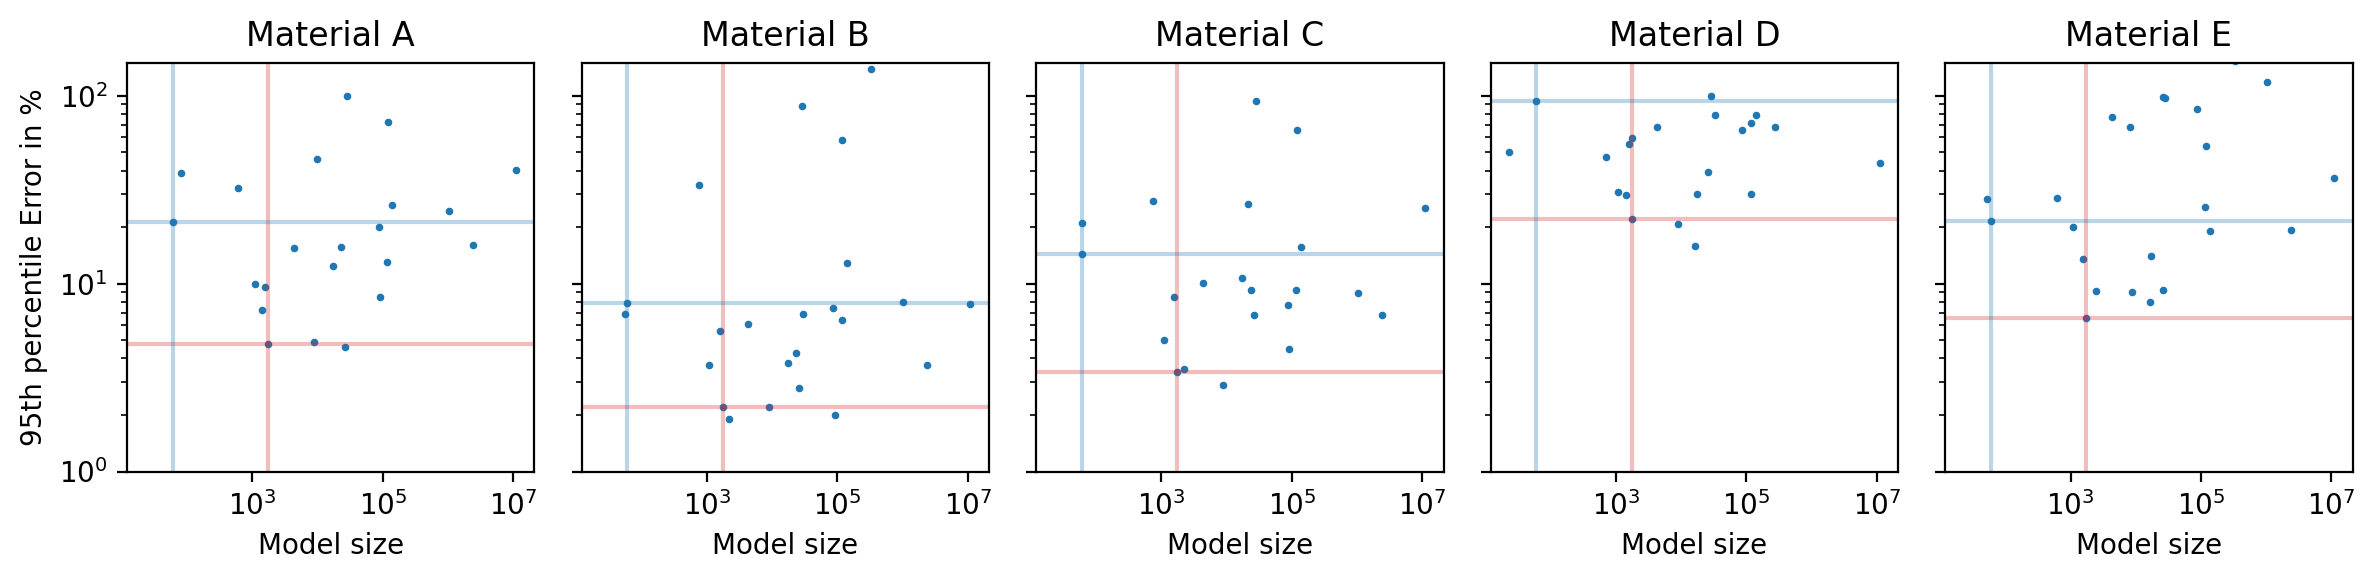

In [24]:
fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(12, 3), dpi=200)
SHOW_BLUE_TEAM = '#9'
for matcol, ax in zip(mat_cols, axes.flatten()):
    ax.scatter(df.loc[:, (matcol, 'Size')], df.loc[:, (matcol, 'Error')],
               s=3.0)
    ax.axvline(1755, color="tab:red", alpha=.3)
    ax.axhline(float(df.loc[df.loc[:, (matcol, 'Size')] == 1755, (matcol, 'Error')].iloc[0]), color='tab:red', alpha=.3)

    ax.axvline(int(df.loc[df.loc[:, (   '       ',  'Team')] == SHOW_BLUE_TEAM, (matcol, 'Size')].iloc[0]), color='tab:blue', alpha=.3)
    ax.axhline(float(df.loc[df.loc[:, (   '       ',  'Team')] == SHOW_BLUE_TEAM, (matcol, 'Error')].iloc[0]), color='tab:blue', alpha=.3)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1, 150)
    #ax.set_ylim(1, 40)
    ax.set_title(matcol)
    ax.set_xlabel('Model size')
    if matcol.endswith('A'):
        ax.set_ylabel('95th percentile Error in %')
    
fig.tight_layout()

In [20]:
df.loc[:, 'mean_error'] = np.column_stack([df.loc[:, (matcol, 'Error')].to_numpy() for matcol in mat_cols]).mean(axis=1)
df.sort_values(by='mean_error').iloc[:10, :]

Material A         Material B         Material C          \
        Team      Error    Size      Error    Size      Error    Size   
1    #2             8.5   90653        2.0   90653        4.5   90653   
12   #13            4.8    1755        2.2    1755        3.4    1755   
3    #4             4.9    8914        2.2    8914        2.9    8914   
20   #21            7.2    1419        1.9    2197        3.5    2197   
5    #6             4.6   25923        2.8   25923        6.8   25923   
17   #18           10.0    1084        3.7    1084        5.0    1084   
22   #23           12.4   17342        3.8   17342       10.7   17342   
19   #20           13.1  116061        6.4  116061        9.3  116061   
0    #1             9.6    1576        5.6    1576        8.5    1576   
15   #16           38.8      81        6.9      56       21.0      61   

   Material D         Material E         mean_error median_error  
        Error    Size      Error    Size                          
1        15.9   16449        8.0   16449       7.78          8.0  
12       22.2    1755        6.6    1755       7.84          4.8  
3        20.7    8914        9.0    8914       7.94          4.9  
20       29.6    1419        9.1    2454      10.26          7.2  
5        39.5   25923        9.3   25923       12.6          6.8  
17       30.7    1084       19.9    1084      13.86         10.0  
22       30.0   17342       14.1   17342       14.2         12.4  
19       29.9  116061       25.7  116061      16.88         13.1  
0        55.3    1576       13.5    1576       18.5          9.6  
15       50.5      23       28.2      53      29.08         28.2

In [21]:
df.loc[:, 'median_error'] = np.median(np.column_stack([df.loc[:, (matcol, 'Error')].to_numpy() for matcol in mat_cols]), axis=1)
df.sort_values(by='median_error').iloc[:10, :]

Material A         Material B         Material C          \
        Team      Error    Size      Error    Size      Error    Size   
12   #13            4.8    1755        2.2    1755        3.4    1755   
3    #4             4.9    8914        2.2    8914        2.9    8914   
5    #6             4.6   25923        2.8   25923        6.8   25923   
20   #21            7.2    1419        1.9    2197        3.5    2197   
1    #2             8.5   90653        2.0   90653        4.5   90653   
0    #1             9.6    1576        5.6    1576        8.5    1576   
17   #18           10.0    1084        3.7    1084        5.0    1084   
22   #23           12.4   17342        3.8   17342       10.7   17342   
19   #20           13.1  116061        6.4  116061        9.3  116061   
23   #24           15.5    4285        6.1    4285       10.1    4285   

   Material D         Material E         mean_error median_error  
        Error    Size      Error    Size                          
12       22.2    1755        6.6    1755       7.84          4.8  
3        20.7    8914        9.0    8914       7.94          4.9  
5        39.5   25923        9.3   25923       12.6          6.8  
20       29.6    1419        9.1    2454      10.26          7.2  
1        15.9   16449        8.0   16449       7.78          8.0  
0        55.3    1576       13.5    1576       18.5          9.6  
17       30.7    1084       19.9    1084      13.86         10.0  
22       30.0   17342       14.1   17342       14.2         12.4  
19       29.9  116061       25.7  116061      16.88         13.1  
23       67.9    4285       77.0    4285      35.32         15.5